In [1]:
import numpy             as np
import matplotlib.pyplot as plt
import time

from tqdm            import tqdm
from scipy           import signal
from scipy.signal    import sosfiltfilt as sff

from propagation import received_power, quad_distribute_power, propagation_delay, \
                        generate_aoa2_rx_signals, generate_rtof_rx_signals, \
                        map_rx_config, map_tx_config

from parameter_measurement import aoa_measurement, rtof_d_measure

from position_estimation import aoa2_positioning, rtof_bechadergue_positioning

# Get configuration

**weather and sunlight conditions**

weather-dependent signal attenuation values for laser-based FSO channels are provided in the following paper:

    Grabner, M., & Kvicera, V. (2013). "Multiple scattering in rain and fog on free-space optical links." Journal of lightwave technology, 32(3), 513-520.
 
we've modified these (considering worst-case approximations) for a vlc channel. Also, sunlight noise values are provided here:

    Moreira, A. J., Valadas, R. T., & de Oliveira Duarte, A. M. (1997). "Optical interference produced by artificial light." Wireless Networks, 3(2), 131-140.

In [2]:
weather     = 'fog' 
temperature = 298 # Kelvin
daynight    = 'day_directsun'


daynight_noise_factors = dict()
daynight_noise_factors['day_directsun']   = 1.000 # 5100 uA
daynight_noise_factors['day_indirectsun'] = 0.145 # 740 uA
daynight_noise_factors['night']           = 0.010 # very small

# minmax bounds to be safe if you set the noise factor yourself
bg_current = (np.minimum(1, np.maximum(0, daynight_noise_factors[daynight]))*5100)*1e-6;

weather_attenuation_factors = dict()
weather_attenuation_factors['clear'] = 0.0
weather_attenuation_factors['rain']  = -0.05
weather_attenuation_factors['fog']   = -0.2

atten = weather_attenuation_factors[weather];

**trajectory**

In [3]:
a = np.load('trajectories/generated_lanechange.npz')

trajectory_partial_numsamples = 1000

In [4]:
L = 1.6 # vehicle width in meters, check below
print("vehicle width, check: ", np.sqrt((a['x_RR']-a['x_RL'])**2+(a['y_RR']-a['y_RL'])**2)[0])

xRL_to_rxL = a['x_RL'][0:trajectory_partial_numsamples]; yRL_to_rxL = a['y_RL'][0:trajectory_partial_numsamples]; 
xRR_to_rxL = a['x_RR'][0:trajectory_partial_numsamples]; yRR_to_rxL = a['y_RR'][0:trajectory_partial_numsamples]
yRL_to_rxR = a['y_RL'][0:trajectory_partial_numsamples]; yRR_to_rxR = a['y_RR'][0:trajectory_partial_numsamples]; 
hdg  = a['hdg'][0:trajectory_partial_numsamples];
xRL_to_rxR = a['x_RL'][0:trajectory_partial_numsamples] - L;
xRR_to_rxR = a['x_RR'][0:trajectory_partial_numsamples] - L;

vehicle width, check:  1.6


In [5]:
f_vehicle = 1e3;         # [Hz], trajectory simulation clock rate, fixed by trajectory generation
t_vehicle = 1/f_vehicle; # [s] , trajectory simulation clock period, fixed by trajectory generation

stop_time = xRL_to_rxL.shape[0]*t_vehicle
print("Simulation length:", stop_time, "seconds")

Simulation length: 1.0 seconds


**optics**

In [6]:
a = np.load('optics/qrx_planoconvex.npz');
f_QRX, pd_snst, pd_gain, pd_dim, rx_P_rx_factor, rx_I_bg_factor, rx_thermal_factor1, rx_thermal_factor2 = map_rx_config(a);

In [7]:
a = np.load('optics/tx_lambertian_20deg_2W.npz')
tx_ha, tx_pwr, tx_norm, tx_lambertian_order = map_tx_config(a);

# Simulate propagation

**channel gain**

get received optical power (whole detector) in Watts

In [8]:
pwr_txL_to_rxL = received_power(xRL_to_rxL, yRL_to_rxL, 0, pd_dim/1000, tx_pwr, tx_norm, tx_lambertian_order, atten)
pwr_txL_to_rxR = received_power(xRL_to_rxR, yRL_to_rxR, 0, pd_dim/1000, tx_pwr, tx_norm, tx_lambertian_order, atten)
pwr_txR_to_rxL = received_power(xRR_to_rxL, yRR_to_rxL, 0, pd_dim/1000, tx_pwr, tx_norm, tx_lambertian_order, atten)
pwr_txR_to_rxR = received_power(xRR_to_rxR, yRR_to_rxR, 0, pd_dim/1000, tx_pwr, tx_norm, tx_lambertian_order, atten)

share that among the 4 quadrants

In [9]:
shared_pwr_txL_to_rxL = quad_distribute_power(xRL_to_rxL, yRL_to_rxL, 0, f_QRX, pwr_txL_to_rxL)
shared_pwr_txL_to_rxR = quad_distribute_power(xRL_to_rxR, yRL_to_rxR, 0, f_QRX, pwr_txL_to_rxR)
shared_pwr_txR_to_rxL = quad_distribute_power(xRR_to_rxL, yRR_to_rxL, 0, f_QRX, pwr_txR_to_rxL)
shared_pwr_txR_to_rxR = quad_distribute_power(xRR_to_rxR, yRR_to_rxR, 0, f_QRX, pwr_txR_to_rxR)

**propagation delay**

speed_of_light defined inside

In [10]:
delay_txL_to_rxL = propagation_delay(xRL_to_rxL, yRL_to_rxL, 0)
delay_txL_to_rxR = propagation_delay(xRL_to_rxR, yRL_to_rxR, 0)
delay_txR_to_rxL = propagation_delay(xRR_to_rxL, yRR_to_rxL, 0)
delay_txR_to_rxR = propagation_delay(xRR_to_rxR, yRR_to_rxR, 0)

# Localization

all localization methods have a certain update rate. We generate the received signals for each update period one by one (w.r.t. the propagation simulation results), add noise, and then apply the methods.

normally we could just generate the whole received signal array at once, but since we're working with time-based methods our sampling rate is on the order of GHz, which results in huge arrays (e.g., 10 GHz sampling, just the time array for a 1 second simulation scenario takes ~40 GB).  

we'll evaluate all methods at 100 Hz

In [11]:
localization_decimation_rate = 10
localization_rate = 1/(t_vehicle*localization_decimation_rate)
localization_num_steps = int(trajectory_partial_numsamples/localization_decimation_rate)
print("localization rate:", localization_rate, "Hz")
print("so each localization period considers", localization_decimation_rate, "trajectory samples")
print("and there are a total of", localization_num_steps, "steps")

localization rate: 100.0 Hz
so each localization period considers 10 trajectory samples
and there are a total of 100 steps


one catch here: our implementation of the rtof algorithm goes bananas when it doeesn't see the gate pulse rising edge at the beginning, so we shift all transmitted signals by $\frac{\pi}{32}$ (arbitrary) and generate signals for 11 trajectory samples instead of 10 (no link to $\frac{\pi}{32}$, just a safe margin). **BUT** the estimation is made for the first 10 samples. So it's not a rolling buffer, we generate signals for each localization step, which regards 10 trajectory steps. 

simulation preliminaries - time

In [12]:
f_simulation = 1e10;           # [Hz], simulation clock freq that should capture light delays amounting to 3cm
t_simulation = 1/f_simulation; # [s] , simulation clock period

simulation_start  = t_simulation; # [s], t_simulation rather than 0 avoids artifacts and sim ends at simulation_stop this way
simulation_stop   = (localization_decimation_rate+1)*t_vehicle; # [s], see note above about pi/32
simulation_length = int(simulation_stop/t_simulation)
print("Simulation stop time:",simulation_stop)
print("Simulation length   :",simulation_length)

s_simulation   = np.linspace(simulation_start, simulation_stop, simulation_length)

vehicle_time_start  = t_vehicle; # [s], t_vehicle rather than 0 avoids artifacts and sim ends at simulation_stop this way
vehicle_time_stop   = simulation_stop;
vehicle_time_length = int(vehicle_time_stop/t_vehicle)
print("Vehicle time for rtof, stop time:", vehicle_time_stop)
print("Vehicle time for rtof, length   :", vehicle_time_length)

s_vehicle_time = np.linspace(vehicle_time_start, vehicle_time_stop, vehicle_time_length)
                             
f_adc_clock  = 1e8;             # [Hz], measurement clock freq
t_adc_clock  = 1/f_adc_clock;   # [s] , measurement clock period

simclock_subsample_rate = int(f_simulation/f_adc_clock)

s_adc_clock = np.zeros_like(s_simulation)
for i in range(0, int(simclock_subsample_rate/2)):
    s_adc_clock[ i::simclock_subsample_rate] = 1;

s_adc_clock_lead  = s_adc_clock[1:]
s_adc_clock_lag   = s_adc_clock[0:-1]
s_adc_clock_re    = np.concatenate((np.asarray([False]), np.logical_and((1-s_adc_clock_lag), s_adc_clock_lead)))
del s_adc_clock, s_adc_clock_lead, s_adc_clock_lag

Simulation stop time: 0.011
Simulation length   : 109999999
Vehicle time for rtof, stop time: 0.011
Vehicle time for rtof, length   : 11


simulation preliminaries - other

In [13]:
f_eL     = 1.0e6; # [Hz], emitted wave freq, left TX
f_eR     = 0.8e6; # [Hz], emitted wave freq, right TX
rtof_r   = 1999;  # unitless, heterodyning factor
rtof_N_L = 10;    # unitless, averaging factor for left TX
rtof_N_R = 8;     # unitless, averaging factor for right TX

c = 299792458 # [m/s] speed of light

### this factor is precomputed since it's the same for all links
# /16 due to C_T^2 in the thermal_factor2, each cell gets 1/4 of the total cap
thermal_and_bg_curr = rx_I_bg_factor*bg_current + temperature*(rx_thermal_factor1 + rx_thermal_factor2/16)

add_noise  = 1

## aoa2

In [14]:
aoa_rxL_txL = np.zeros((localization_num_steps))
aoa_rxR_txL = np.zeros((localization_num_steps))
aoa_rxL_txR = np.zeros((localization_num_steps))
aoa_rxR_txR = np.zeros((localization_num_steps))
est_x_txL = np.zeros((localization_num_steps))
est_y_txL = np.zeros((localization_num_steps))
est_x_txR = np.zeros((localization_num_steps))
est_y_txR = np.zeros((localization_num_steps))

for i in tqdm(range(0, localization_num_steps)):
    #localization_step = 0; # bu for loop olcak
    smp_lo = i*localization_decimation_rate
    smp_hi = (i+1)*localization_decimation_rate

    step_time       = s_vehicle_time[0:int(localization_decimation_rate*s_vehicle_time.shape[0]/(localization_decimation_rate+1))]
    simulation_time = s_simulation[s_adc_clock_re]
    simulation_time = simulation_time[0:int(localization_decimation_rate*simulation_time.shape[0]/(localization_decimation_rate+1))+1]

    rxLL, rxLR, rxRL, rxRR, delays = generate_aoa2_rx_signals(shared_pwr_txL_to_rxL, shared_pwr_txL_to_rxR, shared_pwr_txR_to_rxL, shared_pwr_txR_to_rxR,
                                                            delay_txL_to_rxL, delay_txL_to_rxR, delay_txR_to_rxL, delay_txR_to_rxR,
                                                            f_eL, f_eR, pd_snst, pd_gain, thermal_and_bg_curr, rx_P_rx_factor,
                                                            step_time, simulation_time, smp_lo, smp_hi,
                                                            add_noise);    
    (rxLA_txL, rxLB_txL, rxLC_txL, rxLD_txL) = rxLL
    (rxLA_txR, rxLB_txR, rxLC_txR, rxLD_txR) = rxLR
    (rxRA_txL, rxRB_txL, rxRC_txL, rxRD_txL) = rxRL
    (rxRA_txR, rxRB_txR, rxRC_txR, rxRD_txR) = rxRR 
    (delayLL_sigTime, delayLR_sigTime, delayRL_sigTime, delayRR_sigTime) = delays

    del rxLL, rxLR, rxRL, rxRR, delays 

    # assume that the VLC subsystem correctly decodes the signal
    wav_rxL_txL = np.sin(2*np.pi*f_eL*(simulation_time - delayLL_sigTime))
    wav_rxL_txR = np.sin(2*np.pi*f_eR*(simulation_time - delayLR_sigTime))
    wav_rxR_txL = np.sin(2*np.pi*f_eL*(simulation_time - delayRL_sigTime))
    wav_rxR_txR = np.sin(2*np.pi*f_eR*(simulation_time - delayRR_sigTime))

    thd = 1e-5;

    aoa_rxL_txL[i] = aoa_measurement(rxLA_txL, rxLB_txL, rxLC_txL, rxLD_txL, wav_rxL_txL, f_QRX, thd)
    aoa_rxR_txL[i] = aoa_measurement(rxRA_txL, rxRB_txL, rxRC_txL, rxRD_txL, wav_rxR_txL, f_QRX, thd)
    aoa_rxL_txR[i] = aoa_measurement(rxLA_txR, rxLB_txR, rxLC_txR, rxLD_txR, wav_rxL_txR, f_QRX, thd)
    aoa_rxR_txR[i] = aoa_measurement(rxRA_txR, rxRB_txR, rxRC_txR, rxRD_txR, wav_rxR_txR, f_QRX, thd)

    est_x_txL[i], est_y_txL[i], est_x_txR[i], est_y_txR = aoa2_positioning(aoa_rxL_txL[i], aoa_rxL_txR[i], aoa_rxR_txL[i], aoa_rxR_txR[i], L);

100%|██████████| 100/100 [01:20<00:00,  1.24it/s]


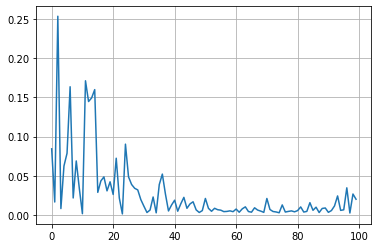

In [15]:
fig, ax = plt.subplots()
error_x = est_x_txL - xRL_to_rxL[int(localization_decimation_rate/2)::localization_decimation_rate]
error_y = est_y_txL - yRL_to_rxL[int(localization_decimation_rate/2)::localization_decimation_rate]
ax.plot(np.sqrt(error_x**2+error_y**2))
ax.grid()
plt.show()

In [16]:
del wav_rxL_txL, wav_rxL_txR, wav_rxR_txL, wav_rxR_txR
del rxLA_txL, rxLB_txL, rxLC_txL, rxLD_txL
del rxLA_txR, rxLB_txR, rxLC_txR, rxLD_txR
del rxRA_txL, rxRB_txL, rxRC_txL, rxRD_txL
del rxRA_txR, rxRB_txR, rxRC_txR, rxRD_txR
del delayLL_sigTime, delayLR_sigTime, delayRL_sigTime, delayRR_sigTime
del simulation_time, step_time

## rtof

In [17]:
sos_lo_het = signal.butter(8, 2*(f_eL*1.20)*t_simulation, 'low', output='sos')
sos_hi_het = signal.butter(8, 2*(f_eL*0.80)*t_simulation, 'high', output='sos')

In [18]:
d_rxL_txL = np.zeros((localization_num_steps))
d_rxR_txL = np.zeros((localization_num_steps))
d_rxL_txR = np.zeros((localization_num_steps))
d_rxR_txR = np.zeros((localization_num_steps))
est_x_txL = np.zeros((localization_num_steps))
est_y_txL = np.zeros((localization_num_steps))
est_x_txR = np.zeros((localization_num_steps))
est_y_txR = np.zeros((localization_num_steps))

rr = 1e6; # zero crossing gets detected at 1/rr of the total swing

for i in tqdm(range(0, localization_num_steps)):
    smp_lo = i*localization_decimation_rate
    if(i==localization_num_steps-1):
        # last localization step will be 10% stretched in time. hope this is negligible...
        smp_hi = (i+1)*localization_decimation_rate
        step_time       = s_vehicle_time[0:int(localization_decimation_rate*s_vehicle_time.shape[0]/(localization_decimation_rate+1))]
    else:
        smp_hi = (i+1)*localization_decimation_rate+1
        step_time       = s_vehicle_time # include the 11th sample, contrary to aoa2 
    
    simulation_time = s_simulation   # don't clock it yet, and keep it compliant with sample 11

    # first left RX
    rxLL, rxLR = generate_rtof_rx_signals(pwr_txL_to_rxL, pwr_txR_to_rxL, delay_txL_to_rxL, delay_txR_to_rxL,
                                          f_eL, f_eR, pd_snst, pd_gain, thermal_and_bg_curr, rx_P_rx_factor,
                                          step_time, simulation_time, smp_lo, smp_hi,
                                          add_noise);
    rxLL = sff(sos_lo_het, sff(sos_hi_het, rxLL));
    rxLR = sff(sos_lo_het, sff(sos_hi_het, rxLR));
    d_rxL_txL[i] = rtof_d_measure(s_simulation, s_adc_clock_re, rxLL, rtof_N_L, rtof_r, f_eL, f_adc_clock, c, rr);
    d_rxL_txR[i] = rtof_d_measure(s_simulation, s_adc_clock_re, rxLR, rtof_N_R, rtof_r, f_eR, f_adc_clock, c, rr);
    del rxLL, rxLR
    
    # then right RX
    rxRL, rxRR = generate_rtof_rx_signals(pwr_txL_to_rxR, pwr_txR_to_rxR, delay_txL_to_rxR, delay_txR_to_rxR,
                                          f_eL, f_eR, pd_snst, pd_gain, thermal_and_bg_curr, rx_P_rx_factor,
                                          step_time, simulation_time, smp_lo, smp_hi,
                                          add_noise);
    rxRR = sff(sos_lo_het, sff(sos_hi_het, rxRR));
    rxRL = sff(sos_lo_het, sff(sos_hi_het, rxRL));
    d_rxR_txL[i] = rtof_d_measure(s_simulation, s_adc_clock_re, rxRL, rtof_N_L, rtof_r, f_eL, f_adc_clock, c, rr);
    d_rxR_txR[i] = rtof_d_measure(s_simulation, s_adc_clock_re, rxRR, rtof_N_R, rtof_r, f_eR, f_adc_clock, c, rr);
    del rxRL, rxRR
    
    # then estimate position
    est_y_txL[i], est_x_txL[i] = rtof_bechadergue_positioning(d_rxL_txL[i], d_rxR_txL[i], L)
    est_y_txR[i], est_x_txR[i] = rtof_bechadergue_positioning(d_rxL_txR[i], d_rxR_txR[i], L)

100%|██████████| 100/100 [1:29:55<00:00, 53.95s/it]


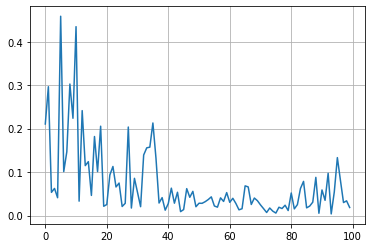

In [19]:
fig, ax = plt.subplots()
error_x = est_x_txL - xRL_to_rxL[int(localization_decimation_rate/2)::localization_decimation_rate]
error_y = est_y_txL - yRL_to_rxL[int(localization_decimation_rate/2)::localization_decimation_rate]
ax.plot(np.sqrt(error_x**2+error_y**2))
ax.grid()
plt.show()

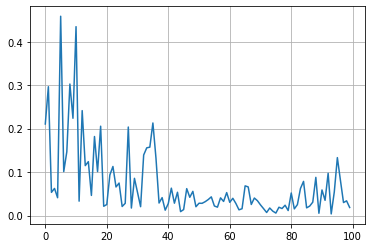

In [20]:
fig, ax = plt.subplots()
error_x = est_x_txL - xRL_to_rxL[int(localization_decimation_rate/2)::localization_decimation_rate]
error_y = est_y_txL - yRL_to_rxL[int(localization_decimation_rate/2)::localization_decimation_rate]
ax.plot(np.sqrt(error_x**2+error_y**2))
ax.grid()
plt.show()

In [ ]:
w, h = signal.sosfreqz(sos_lo_het, worN=100000)

plt.subplot(2, 1, 1)

db = 20*np.log10(np.maximum(np.abs(h), 1e-5))

plt.plot(w/np.pi, db)
plt.xlim([0,0.001])
plt.grid(True)
plt.ylabel('Gain [dB]')
plt.title('Frequency Response')
plt.subplot(2, 1, 2)
plt.plot(w/np.pi, np.angle(h))
plt.grid(True)
plt.xlim([0,0.001])
plt.ylabel('Phase [rad]')
plt.xlabel('Normalized frequency (1.0 = Nyquist)')
plt.show()

In [ ]:
sos_lo_het = signal.butter(8, 2*(f_eL*1.20)*t_simulation, 'low', output='sos')
sos_hi_het = signal.butter(8, 2*(f_eL*0.80)*t_simulation, 'high', output='sos')

In [ ]:
www = np.sin(2*np.pi*1e6*s_simulation)

In [ ]:
wwf = sff(sos_lo_het,sff(sos_hi_het,www)) 

In [ ]:
fig, ax = plt.subplots()
ax.plot(www[0:100000])
ax.plot(wwf[0:100000])
ax.grid()
plt.show()

In [ ]:
sos_lo_het = signal.butter(8, 8*sig_dt*(r+1), 'low', output='sos')

the emitted signal is two delays **ahead** (+) of the received one, so... -1 +2 = +1

In [ ]:
emit_rxL_txL_het = sff(sos_lo_het, np.sin(2*np.pi*txL_carrier*(sig_time + dLL_sigTime))*s_hL);
emit_rxL_txR_het = sff(sos_lo_het, np.sin(2*np.pi*txR_carrier*(sig_time + dLR_sigTime))*s_hR);
emit_rxR_txL_het = sff(sos_lo_het, np.sin(2*np.pi*txL_carrier*(sig_time + dRL_sigTime))*s_hL);
emit_rxR_txR_het = sff(sos_lo_het, np.sin(2*np.pi*txR_carrier*(sig_time + dRR_sigTime))*s_hR);

In [ ]:
def attenuate_edges(signal,time_length,edge_attenuation_percent):
    start = int(np.floor(time_length*edge_attenuation_percent))
    end = int(time_length-start)
    ramp = (1-np.cos(np.pi*(np.arange(start)/start)))/2
    edge_attenuator = np.ones(time_length)
    edge_attenuator[0:start] = ramp
    edge_attenuator[end:time_length] = np.flip(ramp)
    return(signal*edge_attenuator)